In [ ]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Embedding, LSTM, Dense, Conv1D, MaxPooling1D, Flatten, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

In [ ]:
def clean_review_text(text):
    if pd.isna(text):
        return ""
    text = re.sub(r'([nN][ãÃaA][oO]|[ñÑ]| [nN] )', ' negação ', text)
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'R\$', 'dinheiro', text, flags=re.IGNORECASE)
    text = re.sub(r'(.)\1{2,}', r'\1', text)
    text = text.lower()
    return text

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/GabrielVCoutinho/Machine_Learning/main/olist_order_reviews_dataset.csv")
display(df.head())

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [ ]:
# Dropando valores nulos de review
df_clean = df[['review_comment_message', 'review_score']].dropna(subset=['review_comment_message'])

In [ ]:
# Aplicando a função com Regex de limpeza
df['review_comment_message'] = df['review_comment_message'].apply(clean_review_text)

In [ ]:
# Remover stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('portuguese'))
df['review_comment_message'] = df['review_comment_message'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Aplicar stemming
nltk.download('rslp')
stemmer = RSLPStemmer()
df['review_comment_message'] = df['review_comment_message'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


In [ ]:
df_clean = df[['review_comment_message', 'review_score']]
display(df_clean.head())

,review_comment_message,review_score
0,,4
1,,5
2,,5
3,receb bem ant praz estipulado.,5
4,parabém loj lannist ador compr internet segur ...,5


In [ ]:
df_clean = df_clean[df_clean['review_comment_message'] != '']
display(df_clean.head())

,review_comment_message,review_score
3,receb bem ant praz estipulado.,5
4,parabém loj lannist ador compr internet segur ...,5
9,aparelh eficiente. sit marc aparelh impress de...,4
12,"pouc ,travando.pel val ta boa.",4
15,"vend confiável, produt ok entreg ant prazo.",5


In [ ]:
# Binarizar 'review_score'
df_clean['review_score'] = df_clean['review_score'].apply(lambda x: 1 if x > 3 else (0 if x < 3 else None))

# Remover linhas com 'review_score' nulo (que eram 3)
df_clean = df_clean.dropna(subset=['review_score'])

display(df_clean.head())

,review_comment_message,review_score
3,receb bem ant praz estipulado.,1.0
4,parabém loj lannist ador compr internet segur ...,1.0
9,aparelh eficiente. sit marc aparelh impress de...,1.0
12,"pouc ,travando.pel val ta boa.",1.0
15,"vend confiável, produt ok entreg ant prazo.",1.0


In [ ]:
# Dividir os dados
X = df_clean['review_comment_message']
y = df_clean['review_score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Configurações
vocab_size = 5000  # Tamanho do vocabulário
embedding_dim = 100  # Dimensionalidade do embedding
max_length = 100  # Comprimento máximo das sequências

# Tokenização
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train)

# Transformar textos em sequências
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padronizar as sequências
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length)

In [ ]:
# Modelo 1: Rede Neural Densa
model_dense = Sequential()
model_dense.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim))
model_dense.add(Flatten())
model_dense.add(Dense(64, activation='relu'))
model_dense.add(Dense(32, activation='relu'))
model_dense.add(Dense(16, activation='relu'))
model_dense.add(Dense(1, activation='sigmoid'))  # Ativação sigmoide para saída binária

model_dense.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_dense.summary()

# Early stopping e checkpoint
early_stopping_DNN = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
checkpoint_DNN = ModelCheckpoint('best_model_DNN.keras', monitor='val_loss', save_best_only=True)

# Treinamento com visualização
history_DNN = model_dense.fit(
    X_train_pad, y_train,
    epochs=8,
    batch_size=32,
    validation_data=(X_test_pad, y_test),
    callbacks=[early_stopping_DNN, checkpoint_DNN]
)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/8
934/934 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.8634 - loss: 0.3051 - val_accuracy: 0.9240 - val_loss: 0.2101
Epoch 2/8
934/934 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.9457 - loss: 0.1564 - val_accuracy: 0.9230 - val_loss: 0.2166
Epoch 3/8
934/934 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.9671 - loss: 0.1002 - val_accuracy: 0.9179 - val_loss: 0.2376
Epoch 4/8
934/934 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.9800 - loss: 0.0661 - val_accuracy: 0.9103 - val_loss: 0.3182
Epoch 5/8
934/934 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.9836 - loss: 0.0536 - val_accuracy: 0.9138 - val_loss: 0.3333


In [ ]:
# Modelo 2: LSTM
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim))
model_lstm.add(LSTM(128, return_sequences=True))
model_lstm.add(GlobalMaxPooling1D())
model_lstm.add(Dense(64, activation='relu'))
model_lstm.add(Dense(32, activation='relu'))
model_lstm.add(Dense(1, activation='sigmoid'))

model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_lstm.summary()

# Early stopping e checkpoint
early_stopping_LSTM = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
checkpoint_LSTM = ModelCheckpoint('best_model_LSTM.keras', monitor='val_loss', save_best_only=True)

# Treinamento com visualização
history_LSTM = model_lstm.fit(
    X_train_pad, y_train,
    epochs=8,
    batch_size=32,
    validation_data=(X_test_pad, y_test),
    callbacks=[early_stopping_LSTM, checkpoint_LSTM]
)

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_2               │ ?                           │     0 (unbuilt) │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/8
934/934 ━━━━━━━━━━━━━━━━━━━━ 184s 193ms/step - accuracy: 0.8608 - loss: 0.3198 - val_accuracy: 0.9264 - val_loss: 0.2041
Epoch 2/8
934/934 ━━━━━━━━━━━━━━━━━━━━ 204s 196ms/step - accuracy: 0.9418 - loss: 0.1651 - val_accuracy: 0.9233 - val_loss: 0.2110
Epoch 3/8
934/934 ━━━━━━━━━━━━━━━━━━━━ 180s 193ms/step - accuracy: 0.9533 - loss: 0.1404 - val_accuracy: 0.9208 - val_loss: 0.2120
Epoch 4/8
934/934 ━━━━━━━━━━━━━━━━━━━━ 205s 196ms/step - accuracy: 0.9606 - loss: 0.1162 - val_accuracy: 0.9222 - val_loss: 0.2173
Epoch 5/8
934/934 ━━━━━━━━━━━━━━━━━━━━ 189s 203ms/step - accuracy: 0.9679 - loss: 0.0979 - val_accuracy: 0.9201 - val_loss: 0.2430


In [ ]:
# Modelo 3: CNN
model_cnn = Sequential()
model_cnn.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
model_cnn.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(64, activation='relu'))
model_cnn.add(Dense(32, activation='relu'))
model_cnn.add(Dense(1, activation='sigmoid'))

model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_cnn.summary()

# Early stopping e checkpoint
early_stopping_CNN = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
checkpoint_CNN = ModelCheckpoint('best_model_CNN.keras', monitor='val_loss', save_best_only=True)

# Treinamento com visualização
history_CNN = model_cnn.fit(
    X_train_pad, y_train,
    epochs=8,
    batch_size=32,
    validation_data=(X_test_pad, y_test),
    callbacks=[early_stopping_CNN, checkpoint_CNN]
)



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/8
934/934 ━━━━━━━━━━━━━━━━━━━━ 50s 51ms/step - accuracy: 0.8682 - loss: 0.3048 - val_accuracy: 0.9241 - val_loss: 0.2000
Epoch 2/8
934/934 ━━━━━━━━━━━━━━━━━━━━ 80s 49ms/step - accuracy: 0.9478 - loss: 0.1496 - val_accuracy: 0.9273 - val_loss: 0.1995
Epoch 3/8
934/934 ━━━━━━━━━━━━━━━━━━━━ 82s 49ms/step - accuracy: 0.9647 - loss: 0.1088 - val_accuracy: 0.9269 - val_loss: 0.2198
Epoch 4/8
934/934 ━━━━━━━━━━━━━━━━━━━━ 82s 49ms/step - accuracy: 0.9785 - loss: 0.0735 - val_accuracy: 0.9188 - val_loss: 0.2579
Epoch 5/8
934/934 ━━━━━━━━━━━━━━━━━━━━ 47s 50ms/step - accuracy: 0.9858 - loss: 0.0523 - val_accuracy: 0.9204 - val_loss: 0.3093
Epoch 6/8
934/934 ━━━━━━━━━━━━━━━━━━━━ 81s 50ms/step - accuracy: 0.9860 - loss: 0.0480 - val_accuracy: 0.9166 - val_loss: 0.3102


In [ ]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Acurácia
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Perda
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

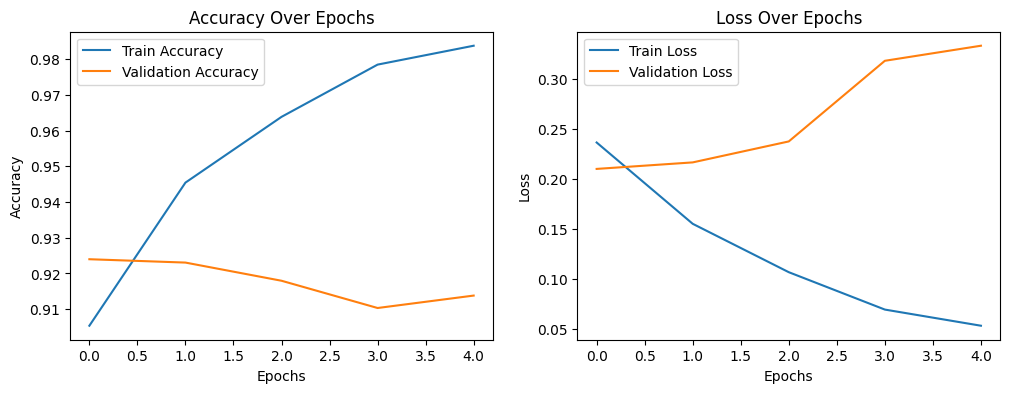

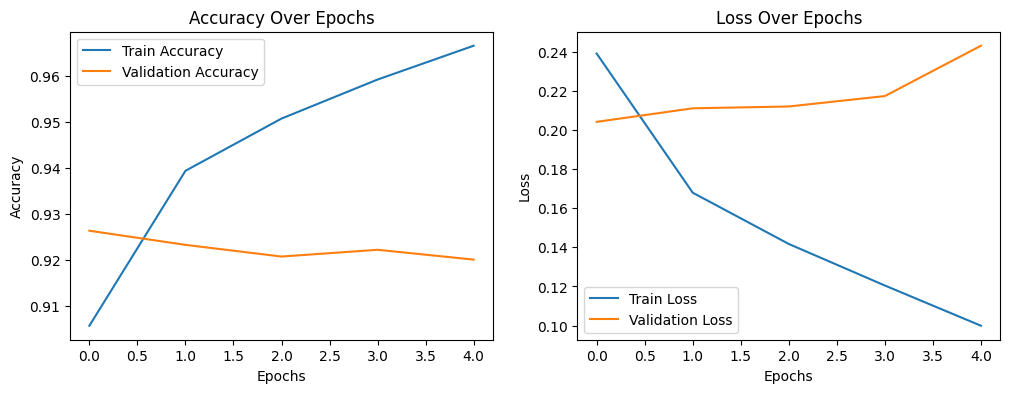

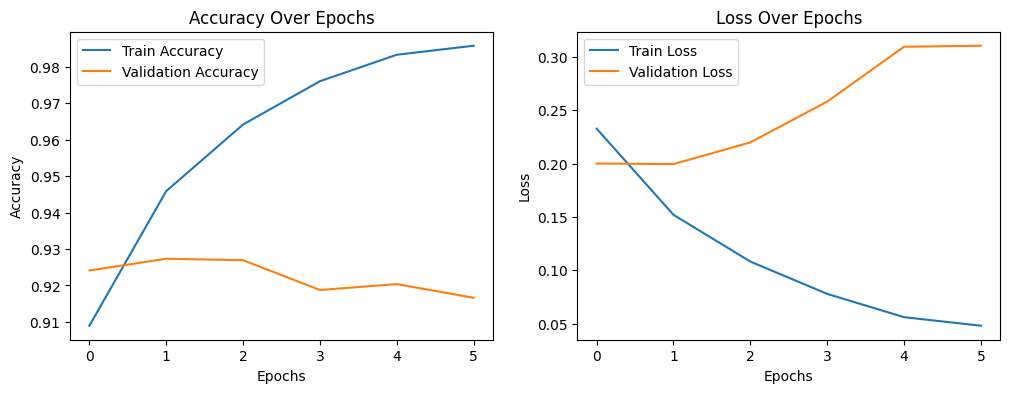

In [ ]:
plot_training_history(history_DNN)
plot_training_history(history_LSTM)
plot_training_history(history_CNN)

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, labels=None, normalize=False, title='Matriz de Confusão'):
    """
    Plota a matriz de confusão com a opção de normalização e exibição de percentuais.

    Parâmetros:
    - y_true: Verdadeiros valores das classes.
    - y_pred: Previsões feitas pelo modelo.
    - labels: Lista de rótulos/classes a serem mostradas no eixo.
    - normalize: Se True, exibe a matriz normalizada (percentual).
    - title: Título da matriz de confusão.
    """
    # Calcula a matriz de confusão
    cm = confusion_matrix(y_true, y_pred, labels=labels, normalize='true' if normalize else None)

    # Configurações do gráfico
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', cmap='Blues',
                xticklabels=labels, yticklabels=labels, cbar_kws={'label': 'Frequência'})

    # Personalizando o gráfico
    plt.title(title)
    plt.xlabel('Previsões')
    plt.ylabel('Valores Verdadeiros')
    plt.show()

# Exemplo de uso:
# plot_confusion_matrix(y_true, y_pred, labels=[0, 1], normalize=True)

234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


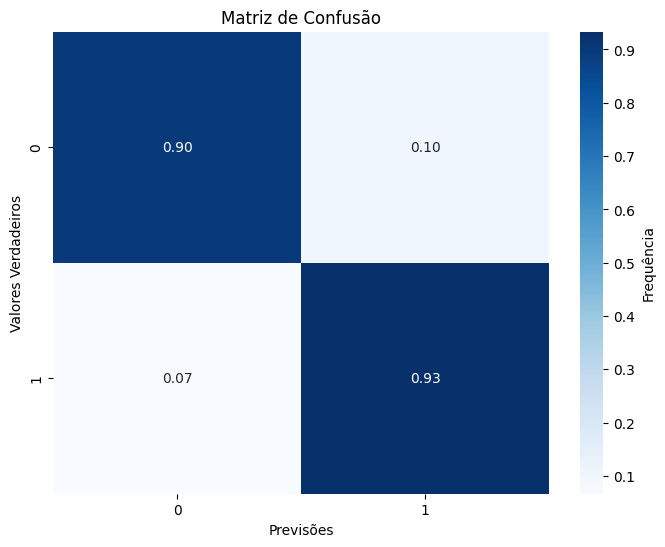

234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step


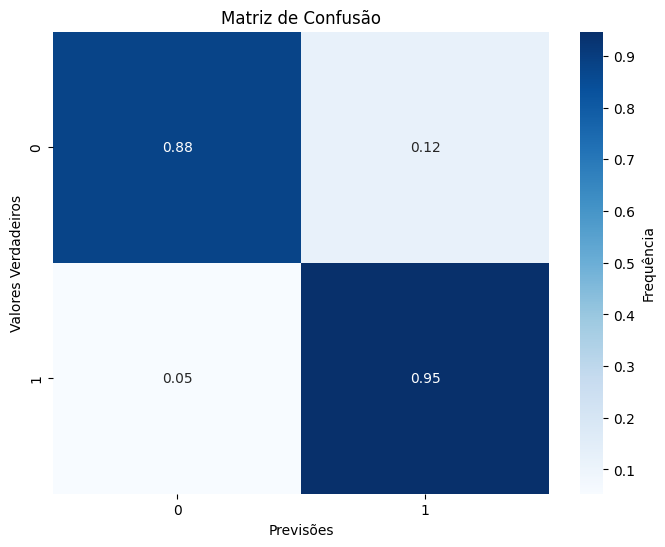

In [ ]:
y_pred_dnn = model_dense.predict(X_test_pad)
y_pred_binary_dnn = (y_pred_dnn > 0.5).astype(int)
plot_confusion_matrix(y_test, y_pred_binary_dnn, labels=[0, 1], normalize=True)

y_pred_cnn = model_cnn.predict(X_test_pad)
y_pred_binary_cnn = (y_pred_cnn > 0.5).astype(int)
plot_confusion_matrix(y_test, y_pred_binary_cnn, labels=[0, 1], normalize=True)



In [ ]:
# Dados dos modelos, acurácias e tempos de execução
dados = {
    'Modelo': ['DNN', 'CNN', 'CNN LSTM', 'CNN GRU', 'BERT'],
    'Acurácia':  ["92.4%", "92.7%", "93%", "92%", "95%"],
    'Tempo de Execução': ['< 1 min.', '7 min.', '20 min.', '1 min.', '45 min.']
}

# Criação do DataFrame
df = pd.DataFrame(dados)

# Define 'Modelo' como índice, mantendo a coluna
df = df.set_index('Modelo', drop=True)

df

,Acurácia,Tempo de Execução
Modelo,,
DNN,92.4%,< 1 min.
CNN,92.7%,7 min.
CNN LSTM,93%,20 min.
CNN GRU,92%,1 min.
BERT,95%,45 min.
